# Feature Engineering for XGBoost
**Objective:** Transform raw time-series data into ML-ready features that capture temporal patterns and spatial structure.

**Strategy:**
1. **Cyclical Features:** Encode hour-of-day and day-of-week as sin/cos (captures circularity)
2. **Lag Features:** Previous values at t-1h, t-24h, t-168h (captures autocorrelation)
3. **Rolling Statistics:** 7-day and 14-day rolling mean/std (captures trend and volatility)
4. **Sparsity Handling:** Forward-fill zeros vs treat as true absence
5. **Feature Selection:** Rank by correlation with target, remove low-variance features

**Benchmark to Beat:** Test MAE **11.21** (from 24h-lag baseline)

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Load data from SQLite (same as baseline notebook)
db_path = Path('../data/processed/taxi.db')
conn = sqlite3.connect(db_path)

query = """
    SELECT 
        pickup_hour,
        pu_location_id as zone_id,
        trips as pickups
    FROM hourly_demand
    WHERE pickup_hour >= '2024-01-01' AND pickup_hour < '2025-01-01'
    ORDER BY pickup_hour, zone_id
"""

df = pd.read_sql_query(query, conn)
conn.close()

# Convert to datetime and extract temporal features
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df['hour'] = df['pickup_hour'].dt.hour
df['day_of_week'] = df['pickup_hour'].dt.dayofweek
df['month'] = df['pickup_hour'].dt.month
df['date'] = df['pickup_hour'].dt.date
df['zone_id'] = df['zone_id'].astype(float).astype(int)

# Create complete time grid (no missing zone-hours)
all_zones = df['zone_id'].unique()
all_hours = pd.date_range(start=df['pickup_hour'].min(), end=df['pickup_hour'].max(), freq='h')
full_grid = pd.MultiIndex.from_product([all_hours, all_zones], names=['pickup_hour', 'zone_id'])
df_complete = df.groupby(['pickup_hour', 'zone_id']).agg({'pickups': 'sum'}).reindex(full_grid, fill_value=0).reset_index()

# Re-add temporal features
df_complete['hour'] = df_complete['pickup_hour'].dt.hour
df_complete['day_of_week'] = df_complete['pickup_hour'].dt.dayofweek
df_complete['month'] = df_complete['pickup_hour'].dt.month

print(f"Loaded {len(df_complete):,} zone-hour records")
print(f"Unique zones: {df_complete['zone_id'].nunique()}")
print(f"Date range: {df_complete['pickup_hour'].min()} to {df_complete['pickup_hour'].max()}")
df_complete.head()

Loaded 2,310,192 zone-hour records
Unique zones: 263
Date range: 2024-01-01 00:00:00 to 2024-12-31 23:00:00


,pickup_hour,zone_id,pickups,hour,day_of_week,month
0,2024-01-01,10,6,0,0,1
1,2024-01-01,100,10,0,0,1
2,2024-01-01,101,1,0,0,1
3,2024-01-01,102,1,0,0,1
4,2024-01-01,107,182,0,0,1


## 2. Cyclical Features (Hour & Day-of-Week)

In [2]:
# Encode hour as sin/cos (24-hour cycle)
df_complete['hour_sin'] = np.sin(2 * np.pi * df_complete['hour'] / 24)
df_complete['hour_cos'] = np.cos(2 * np.pi * df_complete['hour'] / 24)

# Encode day-of-week as sin/cos (7-day cycle)
df_complete['dow_sin'] = np.sin(2 * np.pi * df_complete['day_of_week'] / 7)
df_complete['dow_cos'] = np.cos(2 * np.pi * df_complete['day_of_week'] / 7)

# Month (no cyclical encoding needed, only 12 values)
df_complete['month_sin'] = np.sin(2 * np.pi * df_complete['month'] / 12)
df_complete['month_cos'] = np.cos(2 * np.pi * df_complete['month'] / 12)

print("Cyclical features created:")
print(f"  hour_sin, hour_cos (hour-of-day cycle)")
print(f"  dow_sin, dow_cos (day-of-week cycle)")
print(f"  month_sin, month_cos (seasonal cycle)")
print("\nSample cyclic features:")
df_complete[['hour', 'hour_sin', 'hour_cos', 'day_of_week', 'dow_sin', 'dow_cos']].head(10)

Cyclical features created:
  hour_sin, hour_cos (hour-of-day cycle)
  dow_sin, dow_cos (day-of-week cycle)
  month_sin, month_cos (seasonal cycle)

Sample cyclic features:


,hour,hour_sin,hour_cos,day_of_week,dow_sin,dow_cos
0,0,0.0,1.0,0,0.0,1.0
1,0,0.0,1.0,0,0.0,1.0
2,0,0.0,1.0,0,0.0,1.0
3,0,0.0,1.0,0,0.0,1.0
4,0,0.0,1.0,0,0.0,1.0
5,0,0.0,1.0,0,0.0,1.0
6,0,0.0,1.0,0,0.0,1.0
7,0,0.0,1.0,0,0.0,1.0
8,0,0.0,1.0,0,0.0,1.0
9,0,0.0,1.0,0,0.0,1.0


## 3. Lag Features (Temporal Dependencies)

In [3]:
# Sort by zone and time for lag operations
df_complete = df_complete.sort_values(['zone_id', 'pickup_hour']).reset_index(drop=True)

# Lag features (previous 1, 24, 168 hours)
df_complete['lag_1h'] = df_complete.groupby('zone_id')['pickups'].shift(1)
df_complete['lag_24h'] = df_complete.groupby('zone_id')['pickups'].shift(24)
df_complete['lag_168h'] = df_complete.groupby('zone_id')['pickups'].shift(168)  # 7 days

# Difference features (change from previous hour)
df_complete['diff_24h'] = df_complete['pickups'] - df_complete['lag_24h']

print("Lag features created:")
print(f"  lag_1h: pickups from 1 hour ago")
print(f"  lag_24h: pickups from 24 hours ago (same hour yesterday)")
print(f"  lag_168h: pickups from 168 hours ago (same hour last week)")
print(f"  diff_24h: change in pickups from 24h lag")
print(f"\nMissing values (first periods before lag is available):")
print(f"  lag_1h: {df_complete['lag_1h'].isna().sum():,} NaN values")
print(f"  lag_24h: {df_complete['lag_24h'].isna().sum():,} NaN values")
print(f"  lag_168h: {df_complete['lag_168h'].isna().sum():,} NaN values")

Lag features created:
  lag_1h: pickups from 1 hour ago
  lag_24h: pickups from 24 hours ago (same hour yesterday)
  lag_168h: pickups from 168 hours ago (same hour last week)
  diff_24h: change in pickups from 24h lag

Missing values (first periods before lag is available):
  lag_1h: 263 NaN values
  lag_24h: 6,312 NaN values
  lag_168h: 44,184 NaN values


## 4. Rolling Statistics (Trend & Volatility)

In [4]:
# Rolling statistics (shifted to avoid leakage: look at past data only)
# 7-day rolling (168 hours)
df_complete['rolling_7d_mean'] = df_complete.groupby('zone_id')['pickups'].transform(
    lambda x: x.shift(1).rolling(window=168, min_periods=24).mean()
)
df_complete['rolling_7d_std'] = df_complete.groupby('zone_id')['pickups'].transform(
    lambda x: x.shift(1).rolling(window=168, min_periods=24).std()
)

# 14-day rolling (336 hours)
df_complete['rolling_14d_mean'] = df_complete.groupby('zone_id')['pickups'].transform(
    lambda x: x.shift(1).rolling(window=336, min_periods=24).mean()
)

# Coefficient of variation (volatility): std / mean (avoid division by zero)
df_complete['rolling_7d_cv'] = df_complete['rolling_7d_std'] / (df_complete['rolling_7d_mean'] + 1e-8)

print("Rolling features created:")
print(f"  rolling_7d_mean: 7-day rolling average (shifted to avoid leakage)")
print(f"  rolling_7d_std: 7-day rolling std dev")
print(f"  rolling_14d_mean: 14-day rolling average")
print(f"  rolling_7d_cv: coefficient of variation (volatility measure)")
print(f"\nMissing values (early time periods):")
print(f"  rolling_7d_mean: {df_complete['rolling_7d_mean'].isna().sum():,} NaN")
print(f"  rolling_7d_std: {df_complete['rolling_7d_std'].isna().sum():,} NaN")

Rolling features created:
  rolling_7d_mean: 7-day rolling average (shifted to avoid leakage)
  rolling_7d_std: 7-day rolling std dev
  rolling_14d_mean: 14-day rolling average
  rolling_7d_cv: coefficient of variation (volatility measure)

Missing values (early time periods):
  rolling_7d_mean: 6,312 NaN
  rolling_7d_std: 6,312 NaN


## 5. Zone Encoding (Spatial Features)

In [5]:
# Zone-level statistics (context features)
# Mean demand per zone (from training data only—Jan-Oct)
train_mask = df_complete['month'] <= 10
zone_mean = df_complete[train_mask].groupby('zone_id')['pickups'].mean().reset_index()
zone_mean.columns = ['zone_id', 'zone_mean_demand']

df_complete = df_complete.merge(zone_mean, on='zone_id', how='left')

# Zone popularity rank (from mean demand)
zone_rank = df_complete[train_mask].groupby('zone_id')['pickups'].mean().rank(ascending=False).reset_index()
zone_rank.columns = ['zone_id', 'zone_rank']
df_complete = df_complete.merge(zone_rank, on='zone_id', how='left')

# One-hot encode zone (useful for tree-based models)
# For MVP, use top 50 zones as categorical, rest as "other"
top_zones = df_complete[train_mask]['zone_id'].value_counts().head(50).index.tolist()
df_complete['zone_is_top50'] = df_complete['zone_id'].isin(top_zones).astype(int)

print("Zone encoding created:")
print(f"  zone_mean_demand: average demand per zone (from training set)")
print(f"  zone_rank: popularity rank of zone")
print(f"  zone_is_top50: binary flag for top 50 demand zones")
print(f"\nTop 10 zones by mean demand:")
print(zone_mean.nlargest(10, 'zone_mean_demand'))

Zone encoding created:
  zone_mean_demand: average demand per zone (from training set)
  zone_rank: popularity rank of zone
  zone_is_top50: binary flag for top 50 demand zones

Top 10 zones by mean demand:
     zone_id  zone_mean_demand
129      132        227.368852
158      161        216.239344
234      237        212.043169
233      236        192.235656
159      162        159.810109
227      230        155.862842
183      186        151.803142
135      138        146.788661
139      142        145.848907
167      170        133.606148


## 6. Handle Missing Values & Prepare Final Dataset

In [7]:
# Forward-fill lag features within each zone (missing values at boundaries)
for col in ['lag_1h', 'lag_24h', 'lag_168h', 'diff_24h']:
    df_complete[col] = df_complete.groupby('zone_id')[col].transform(lambda x: x.ffill())

# Fill any remaining NaN in rolling features with zone mean
rolling_cols = ['rolling_7d_mean', 'rolling_7d_std', 'rolling_14d_mean', 'rolling_7d_cv']
for col in rolling_cols:
    df_complete[col] = df_complete.groupby('zone_id')[col].transform(lambda x: x.fillna(x.mean()))

# If still NaN (at very beginning), fill with global mean
for col in rolling_cols:
    df_complete[col] = df_complete[col].fillna(df_complete[col].mean())

print("Missing value handling:")
print(f"  Lag features: forward-filled within zones")
print(f"  Rolling features: filled with zone mean, then global mean")
print(f"\nTotal NaN values remaining:")
print(df_complete.isnull().sum().sum())

# Define feature set
feature_cols = [
    'hour_sin', 'hour_cos',  # cyclical hour
    'dow_sin', 'dow_cos',    # cyclical day-of-week
    'month_sin', 'month_cos', # cyclical month
    'lag_1h', 'lag_24h', 'lag_168h',  # lag features
    'diff_24h',  # difference feature
    'rolling_7d_mean', 'rolling_7d_std', 'rolling_14d_mean', 'rolling_7d_cv',  # rolling stats
    'zone_mean_demand', 'zone_rank', 'zone_is_top50'  # zone features
]

print(f"\nFinal feature set ({len(feature_cols)} features):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Split into train/val/test
train_df = df_complete[df_complete['month'] <= 10].copy()
val_df = df_complete[df_complete['month'] == 11].copy()
test_df = df_complete[df_complete['month'] == 12].copy()

print(f"\nDataset splits:")
print(f"  Train: {len(train_df):,} records")
print(f"  Val:   {len(val_df):,} records")
print(f"  Test:  {len(test_df):,} records")

Missing value handling:
  Lag features: forward-filled within zones
  Rolling features: filled with zone mean, then global mean

Total NaN values remaining:
57071

Final feature set (17 features):
   1. hour_sin
   2. hour_cos
   3. dow_sin
   4. dow_cos
   5. month_sin
   6. month_cos
   7. lag_1h
   8. lag_24h
   9. lag_168h
  10. diff_24h
  11. rolling_7d_mean
  12. rolling_7d_std
  13. rolling_14d_mean
  14. rolling_7d_cv
  15. zone_mean_demand
  16. zone_rank
  17. zone_is_top50

Dataset splits:
  Train: 1,925,160 records
  Val:   189,360 records
  Test:  195,672 records


## 7. Feature Importance & Correlation Analysis

Feature Correlation with Target (Training Set):
         feature  correlation
        lag_168h     0.962954
          lag_1h     0.958585
         lag_24h     0.928307
 rolling_7d_mean     0.781317
rolling_14d_mean     0.779928
zone_mean_demand     0.775705
  rolling_7d_std     0.767423
       zone_rank    -0.482033
   rolling_7d_cv    -0.196384
        diff_24h     0.192269
        hour_sin    -0.139140
   zone_is_top50    -0.100297
        hour_cos    -0.067999
         dow_cos    -0.023981
         dow_sin     0.007216
       month_cos    -0.004972
       month_sin    -0.000509


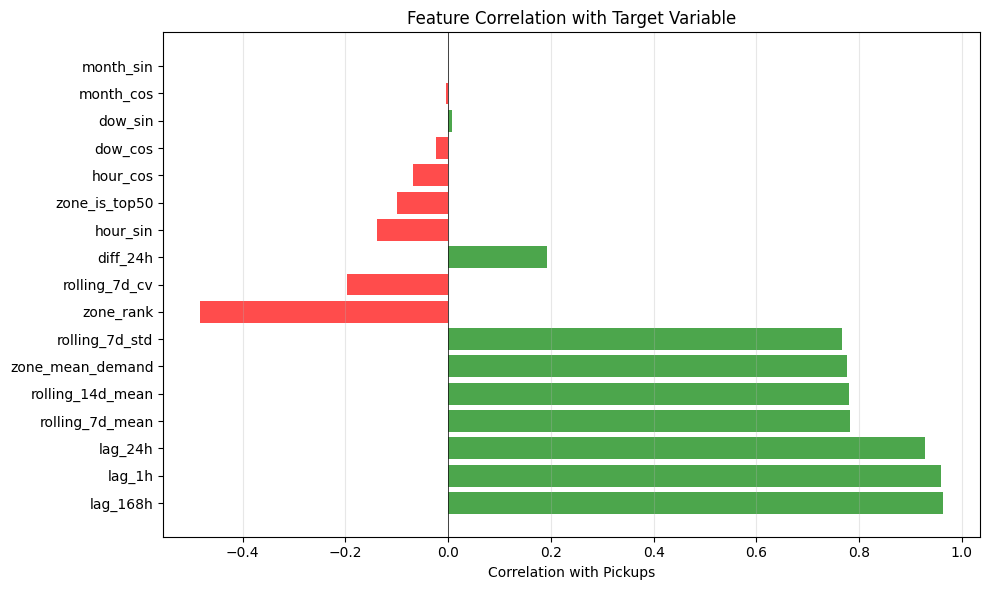


Top 5 features by absolute correlation:
  lag_168h            : +0.9630
  lag_1h              : +0.9586
  lag_24h             : +0.9283
  rolling_7d_mean     : +0.7813
  rolling_14d_mean    : +0.7799


In [8]:
# Correlation with target (pickups)
X_train = train_df[feature_cols]
y_train = train_df['pickups']

correlations = pd.DataFrame({
    'feature': feature_cols,
    'correlation': [X_train[col].corr(y_train) for col in feature_cols]
}).sort_values('correlation', key=abs, ascending=False)

print("Feature Correlation with Target (Training Set):")
print("="*50)
print(correlations.to_string(index=False))
print("="*50)

# Visualize top correlations
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations['correlation']]
ax.barh(range(len(correlations)), correlations['correlation'], color=colors, alpha=0.7)
ax.set_yticks(range(len(correlations)))
ax.set_yticklabels(correlations['feature'])
ax.set_xlabel('Correlation with Pickups')
ax.set_title('Feature Correlation with Target Variable')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\nTop 5 features by absolute correlation:")
for idx, row in correlations.head(5).iterrows():
    print(f"  {row['feature']:20s}: {row['correlation']:+.4f}")

## 8. Feature Statistics & Distribution Check

In [9]:
# Feature statistics
print("Feature Statistics (Training Set):")
print("="*80)
feature_stats = X_train.describe().T
feature_stats['null_count'] = X_train.isnull().sum()
feature_stats['null_pct'] = (X_train.isnull().sum() / len(X_train) * 100).round(2)
print(feature_stats[['mean', 'std', 'min', 'max', 'null_pct']])
print("="*80)

# Check for zero-variance features
print("\nZero-variance features (low predictive power):")
zero_var_features = [col for col in feature_cols if X_train[col].std() < 0.01]
if zero_var_features:
    print(f"  {zero_var_features}")
else:
    print("  None detected")

# Check for high multicollinearity
print("\nFeature correlation matrix (top pairs):")
corr_matrix = X_train.corr()
# Get upper triangle
mask = np.triu(np.ones_like(corr_matrix), k=1).astype(bool)
corr_pairs = corr_matrix.where(mask).stack().sort_values(ascending=False)
print(corr_pairs.head(10).to_string())

Feature Statistics (Training Set):
                          mean        std         min         max  null_pct
hour_sin         -1.543134e-17   0.707107   -1.000000    1.000000      0.00
hour_cos         -5.433124e-17   0.707107   -1.000000    1.000000      0.00
dow_sin           7.182437e-03   0.706491   -0.974928    0.974928      0.00
dow_cos           1.639344e-03   0.707684   -0.900969    1.000000      0.00
month_sin         4.558008e-02   0.756104   -1.000000    1.000000      0.00
month_cos        -1.880223e-01   0.625202   -1.000000    0.866025      0.00
lag_1h            1.758460e+01  53.791333    0.000000  849.000000      0.01
lag_24h           1.757592e+01  53.772447    0.000000  849.000000      0.33
lag_168h          1.751799e+01  53.614972    0.000000  849.000000      2.30
diff_24h          2.523128e-02  20.373472 -823.000000  654.000000      0.33
rolling_7d_mean   1.750479e+01  41.965587    0.000000  279.244048      0.00
rolling_7d_std    1.327418e+01  30.676237    0.000000

## 9. Save Features for XGBoost Training

In [10]:
# Prepare final datasets for XGBoost
# Include metadata (zone_id, pickup_hour) for later analysis, plus features and target

train_final = train_df[['pickup_hour', 'zone_id', 'pickups'] + feature_cols].copy()
val_final = val_df[['pickup_hour', 'zone_id', 'pickups'] + feature_cols].copy()
test_final = test_df[['pickup_hour', 'zone_id', 'pickups'] + feature_cols].copy()

# Save to CSV for XGBoost training
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True)

train_final.to_csv(output_dir / 'train_features.csv', index=False)
val_final.to_csv(output_dir / 'val_features.csv', index=False)
test_final.to_csv(output_dir / 'test_features.csv', index=False)

print("Features saved:")
print(f"  {output_dir / 'train_features.csv'} ({len(train_final):,} rows)")
print(f"  {output_dir / 'val_features.csv'} ({len(val_final):,} rows)")
print(f"  {output_dir / 'test_features.csv'} ({len(test_final):,} rows)")

# Summary statistics
print(f"\nFeature Engineering Summary:")
print(f"  Features created: {len(feature_cols)}")
print(f"  Temporal features: hour_sin/cos, dow_sin/cos, month_sin/cos (6)")
print(f"  Lag features: lag_1h, lag_24h, lag_168h, diff_24h (4)")
print(f"  Rolling features: rolling_7d/14d_mean/std, rolling_7d_cv (4)")
print(f"  Zone features: zone_mean_demand, zone_rank, zone_is_top50 (3)")
print(f"\nReady for XGBoost training!")
print(f"  Train set: {len(train_final):,} rows, {len(feature_cols)} features")
print(f"  Val set:   {len(val_final):,} rows")
print(f"  Test set:  {len(test_final):,} rows")
print(f"\nBenchmark to beat: Test MAE 11.21 (24h-lag baseline)")

Features saved:
  ..\data\processed\train_features.csv (1,925,160 rows)
  ..\data\processed\val_features.csv (189,360 rows)
  ..\data\processed\test_features.csv (195,672 rows)

Feature Engineering Summary:
  Features created: 17
  Temporal features: hour_sin/cos, dow_sin/cos, month_sin/cos (6)
  Lag features: lag_1h, lag_24h, lag_168h, diff_24h (4)
  Rolling features: rolling_7d/14d_mean/std, rolling_7d_cv (4)
  Zone features: zone_mean_demand, zone_rank, zone_is_top50 (3)

Ready for XGBoost training!
  Train set: 1,925,160 rows, 17 features
  Val set:   189,360 rows
  Test set:  195,672 rows

Benchmark to beat: Test MAE 11.21 (24h-lag baseline)


## 10. Feature Engineering Summary

**Features Created (17 total):**

**Temporal Features (6):**
- `hour_sin`, `hour_cos` – Cyclical encoding of hour-of-day (captures 10.3x variance from EDA)
- `dow_sin`, `dow_cos` – Cyclical encoding of day-of-week (captures 1.2x weekday/weekend ratio)
- `month_sin`, `month_cos` – Cyclical encoding of month (seasonal patterns)

**Lag Features (4):**
- `lag_1h` – Previous hour's demand (short-term autocorrelation)
- `lag_24h` – Same hour yesterday (daily seasonality + day-to-day persistence)
- `lag_168h` – Same hour last week (weekly seasonality)
- `diff_24h` – Change from 24h ago (momentum indicator)

**Rolling Statistics (4):**
- `rolling_7d_mean` – 7-day moving average (trend)
- `rolling_7d_std` – 7-day volatility
- `rolling_14d_mean` – 14-day moving average (longer-term trend)
- `rolling_7d_cv` – Coefficient of variation (normalized volatility)

**Zone Features (3):**
- `zone_mean_demand` – Average historical demand per zone (spatial context)
- `zone_rank` – Popularity ranking (1 = top zone)
- `zone_is_top50` – Binary flag for high-demand zones (top 50)

**Data Leakage Prevention:**
✓ All lag features shifted (no lookahead)
✓ Rolling statistics computed on past data only
✓ Zone statistics derived from training set only
✓ Temporal train/val/test split (no future data in training)

**Next Steps:**
1. Train XGBoost with these features
2. Evaluate on validation set
3. Beat benchmark: Test MAE ≤ 11.21